#Image Caption Generator

In this task, I will generate a textual description of an image. It involves Computer vision and Natural Language processing.<br>
In this task, I will be using CNN and LSTM to generate captions for images. We will be using pre-trained model ResNet50 to extract features.

###Dataset Used:
Flickr8k dataset<br>
[dataset link](https://www.kaggle.com/srbhshinde/flickr8k-sau)

###Importing dataset from kaggle

In [1]:
#install kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyachhoriya","key":"09c39403d20f852515e2836cb7aba71f"}'}

In [3]:
#creating a directory
!mkdir ~/.kaggle

In [4]:
#copy kaggle.json file to the directory created
! cp kaggle.json ~/.kaggle/

In [5]:
#change permission
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d srbhshinde/flickr8k-sau

100% 2.07G/2.08G [00:23<00:00, 38.5MB/s]
100% 2.08G/2.08G [00:23<00:00, 95.8MB/s]


In [7]:
!unzip flickr8k-sau.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k-sau/Flickr_Data/Images/2844747252_64567cf14a.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2848266893_9693c66275.jpg  


###Importing libraries

In [ ]:
import numpy as np
import string
import pandas as pd
from matplotlib import pyplot as plt
import keras
import tensorflow as tf
import re
import json
from time import time
from glob import glob
import cv2
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [ ]:
images_file = '/content/flickr8k-sau/Flickr_Data/Images/'  #path of Images folder
images = glob(images_file+'*.jpg')

In [ ]:
len(images)

8091

In [ ]:
images[0]

'/content/flickr8k-sau/Flickr_Data/Images/3154693053_cfcd05c226.jpg'

In [ ]:
#to retrieve only the image name
images[0].split('/')[-1]

'3154693053_cfcd05c226.jpg'

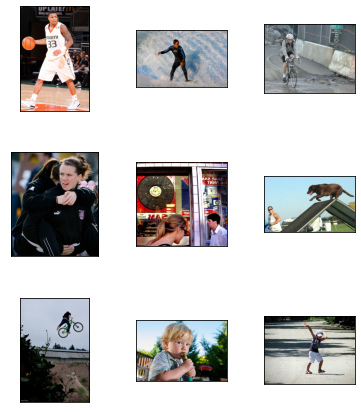

In [ ]:
#plotting some images from Images folder
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.xticks([])
    plt.yticks([])
    img = cv2.imread(images[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  #since cv2 reads image in BGR format so we convert it into RGB format

plt.subplots_adjust(left=0.1,
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)

In [ ]:
caption_file = "/content/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"  #caption path

In [ ]:
caption = open(caption_file, 'rb').read().decode('utf-8').split('\n')

In [ ]:
len(caption)

40461

In [ ]:
caption[:5]   #first 5 captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [ ]:
#to retrieve only the caption
caption[0].split('\t')[1]

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [ ]:
#combining the image name with their captions
#each image have 5 captions
description = {}
for i in range(len(caption)-1):
  t = caption[i].split("\t")
  img_n = t[0].split('.')[0]
  if description.get(img_n) == None:
    description[img_n] = []
  description[img_n].append(t[1])

In [ ]:
len(description)

8092

In [ ]:
description

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

###Cleaning

In [ ]:
def cleaning(text):
  text = text.lower()   #convert text to lower case
  text = re.sub("[^a-z]+"," ",text)   # removing numbers, special characters
  text=text.split()
  text = [t for t in text if len(t)>1]
  text = " ".join(text)
  return text

In [ ]:
for i,j in description.items():
  for k in range(len(j)):
    j[k] = cleaning(j[k])

In [ ]:
description

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [ ]:
desc_to_show = {}
for i in range(len(caption)-1):
  t = caption[i].split("#")
  if t[0] in desc_to_show:
    desc_to_show[t[0]].append(t[1][2:])
  else:
    desc_to_show[t[0]] = [t[1][2:]]

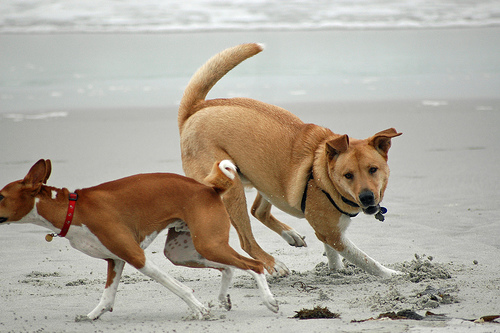

Two different breeds of brown and white dogs play on the beach .
Two dogs are making a turn on a soft sand beach .
Two dogs playing in the sand at the beach .
Two dogs playing together on a beach .
Two large tan dogs play along a sandy beach .


In [ ]:
#showing an image with its 5 captions
from IPython.display import Image, display
t = caption[100].split("#")
z = Image(filename=images_file+"/"+t[0])
display(z)
for i in range(len(desc_to_show[t[0]])):
  print(desc_to_show[t[0]][i])

In [ ]:
vocabulary = set()   #adding unique words to vocabulary
for keys in description.keys():
  [vocabulary.update(i.split()) for i in description[keys]]

In [ ]:
len(vocabulary)

8424

In [ ]:
vocabulary

{'dust',
 'pincer',
 'missed',
 'flowery',
 'poms',
 'crowd',
 'miscellaneous',
 'draping',
 'dirtbikers',
 'folks',
 'musicans',
 'necklace',
 'speeding',
 'trotting',
 'follows',
 'features',
 'introduces',
 'cry',
 'pees',
 'raced',
 'dumbbell',
 'strollers',
 'dirtracing',
 'smooth',
 'backback',
 'herbs',
 'recital',
 'rushed',
 'saxaphones',
 'cobbled',
 'spelunkers',
 'contemplating',
 'softdrinks',
 'cds',
 'customer',
 'batting',
 'gra',
 'hooding',
 'directing',
 'indigo',
 'frozen',
 'shorthair',
 'winning',
 'swimcap',
 'hole',
 'boat',
 'mosaic',
 'crawling',
 'readied',
 'confronted',
 'aisle',
 'couple',
 'shine',
 'timeout',
 'recline',
 'in',
 'diamond',
 'eyese',
 'cartwheels',
 'ten',
 'piggy',
 'headress',
 'flats',
 'coconut',
 'overpass',
 'prays',
 'escorted',
 'bit',
 'watersports',
 'oriential',
 'adjust',
 'clemson',
 'handicapped',
 'film',
 'midst',
 'manequins',
 'muffs',
 'hi',
 'collide',
 'cradling',
 'boarding',
 'fire',
 'calm',
 'clears',
 'strewn',
 

In [ ]:
a_vocab = []
for i in description.keys():
  [a_vocab.append(j) for desc in description[i] for j in desc.split()]

In [ ]:
import collections 
c = collections.Counter(a_vocab)
d = dict(c)
t = 10
sorted_d = sorted(d.items(), reverse=True, key = lambda x:x[1])
sorted_d = [x for x in sorted_d if x[1]>t]
a_vocab = [x[0] for x in sorted_d]

In [ ]:
len(a_vocab)

1845

In [ ]:
a_vocab

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'at',
 'people',
 'water',
 'red',
 'young',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'shirt',
 'down',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'person',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'holding',
 'up',
 'field',
 'small',
 'by',
 'large',
 'green',
 'one',
 'group',
 'yellow',
 'her',
 'walking',
 'children',
 'men',
 'into',
 'air',
 'beach',
 'near',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'off',
 'out',
 'rock',
 'next',
 'play',
 'orange',
 'looking',
 'pink',
 'player',
 'camera',
 'their',
 'pool',
 'hat',
 'jacket',
 'boys',
 'women',
 'around',
 'behind',
 'some',
 'background',
 'dirt',
 'toy',
 'soccer',
 'sits',
 'dressed',
 

In [ ]:
#training images
f = open('/content/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')
train = f.read()
f.close()

In [ ]:
train

'2513260012_03d33305cf.jpg\n2903617548_d3e38d7f88.jpg\n3338291921_fe7ae0c8f8.jpg\n488416045_1c6d903fe0.jpg\n2644326817_8f45080b87.jpg\n218342358_1755a9cce1.jpg\n2501968935_02f2cd8079.jpg\n2699342860_5288e203ea.jpg\n2638369467_8fc251595b.jpg\n2926786902_815a99a154.jpg\n2851304910_b5721199bc.jpg\n3423802527_94bd2b23b0.jpg\n3356369156_074750c6cc.jpg\n2294598473_40637b5c04.jpg\n1191338263_a4fa073154.jpg\n2380765956_6313d8cae3.jpg\n3197891333_b1b0fd1702.jpg\n3119887967_271a097464.jpg\n2276499757_b44dc6f8ce.jpg\n2506892928_7e79bec613.jpg\n2187222896_c206d63396.jpg\n2826769554_85c90864c9.jpg\n3097196395_ec06075389.jpg\n3603116579_4a28a932e2.jpg\n3339263085_6db9fd0981.jpg\n2532262109_87429a2cae.jpg\n2076906555_c20dc082db.jpg\n2502007071_82a8c639cf.jpg\n3113769557_9edbb8275c.jpg\n3325974730_3ee192e4ff.jpg\n1655781989_b15ab4cbff.jpg\n1662261486_db967930de.jpg\n2410562803_56ec09f41c.jpg\n2469498117_b4543e1460.jpg\n69710415_5c2bfb1058.jpg\n3414734842_beb543f400.jpg\n3006217970_90b42e6b27.jpg\n2192

In [ ]:
train = [i.split('.')[0] for i in train.split('\n')[:-1]]

In [ ]:
train = train[:3000]
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [ ]:
len(train)

3000

In [ ]:
 #test images
 f = open('/content/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')
 test = f.read()
 f.close()

In [ ]:
test

'3385593926_d3e9c21170.jpg\n2677656448_6b7e7702af.jpg\n311146855_0b65fdb169.jpg\n1258913059_07c613f7ff.jpg\n241347760_d44c8d3a01.jpg\n2654514044_a70a6e2c21.jpg\n2339106348_2df90aa6a9.jpg\n256085101_2c2617c5d0.jpg\n280706862_14c30d734a.jpg\n3072172967_630e9c69d0.jpg\n3482062809_3b694322c4.jpg\n1167669558_87a8a467d6.jpg\n2847615962_c330bded6e.jpg\n3344233740_c010378da7.jpg\n2435685480_a79d42e564.jpg\n3110649716_c17e14670e.jpg\n2511019188_ca71775f2d.jpg\n2521770311_3086ca90de.jpg\n2723477522_d89f5ac62b.jpg\n2218609886_892dcd6915.jpg\n3745451546_fc8ec70cbd.jpg\n2844018783_524b08e5aa.jpg\n3100251515_c68027cc22.jpg\n2207244634_1db1a1890b.jpg\n2943023421_e297f05e11.jpg\n3286822339_5535af6b93.jpg\n2479652566_8f9fac8af5.jpg\n1394368714_3bc7c19969.jpg\n872622575_ba1d3632cc.jpg\n2309860995_c2e2a0feeb.jpg\n241347204_007d83e252.jpg\n3502343542_f9b46688e5.jpg\n757332692_6866ae545c.jpg\n2748729903_3c7c920c4d.jpg\n494792770_2c5f767ac0.jpg\n3213992947_3f3f967a9f.jpg\n2295750198_6d152d7ceb.jpg\n23588980

In [ ]:
test = [i.split('.')[0] for i in test.split('\n')[:-1]]

In [ ]:
test

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01',
 '2654514044_a70a6e2c21',
 '2339106348_2df90aa6a9',
 '256085101_2c2617c5d0',
 '280706862_14c30d734a',
 '3072172967_630e9c69d0',
 '3482062809_3b694322c4',
 '1167669558_87a8a467d6',
 '2847615962_c330bded6e',
 '3344233740_c010378da7',
 '2435685480_a79d42e564',
 '3110649716_c17e14670e',
 '2511019188_ca71775f2d',
 '2521770311_3086ca90de',
 '2723477522_d89f5ac62b',
 '2218609886_892dcd6915',
 '3745451546_fc8ec70cbd',
 '2844018783_524b08e5aa',
 '3100251515_c68027cc22',
 '2207244634_1db1a1890b',
 '2943023421_e297f05e11',
 '3286822339_5535af6b93',
 '2479652566_8f9fac8af5',
 '1394368714_3bc7c19969',
 '872622575_ba1d3632cc',
 '2309860995_c2e2a0feeb',
 '241347204_007d83e252',
 '3502343542_f9b46688e5',
 '757332692_6866ae545c',
 '2748729903_3c7c920c4d',
 '494792770_2c5f767ac0',
 '3213992947_3f3f967a9f',
 '2295750198_6d152d7ceb',
 '2358898017_24496b80e8',
 '3222055946_45f7293

In [ ]:
len(test)

1000

In [ ]:
#adding sos and eos in every sentence
train_desc = {}
for i in train:
  train_desc[i] = []
  for capt in description[i]:
    cap = 'sos ' + capt + ' eos'  #sos: start of sequence, eos: end of sequence
    train_desc[i].append(cap)

In [ ]:
train_desc

{'2513260012_03d33305cf': ['sos black dog is running after white dog in the snow eos',
  'sos black dog chasing brown dog through snow eos',
  'sos two dogs chase each other across the snowy ground eos',
  'sos two dogs play together in the snow eos',
  'sos two dogs running through low lying body of water eos'],
 '2903617548_d3e38d7f88': ['sos little baby plays croquet eos',
  'sos little girl plays croquet next to truck eos',
  'sos the child is playing croquette by the truck eos',
  'sos the kid is in front of car with put and ball eos',
  'sos the little boy is playing with croquet hammer and ball beside the car eos'],
 '3338291921_fe7ae0c8f8': ['sos brown dog in the snow has something hot pink in its mouth eos',
  'sos brown dog in the snow holding pink hat eos',
  'sos brown dog is holding pink shirt in the snow eos',
  'sos dog is carrying something pink in its mouth while walking through the snow eos',
  'sos dog with something pink in its mouth is looking forward eos'],
 '4884

In [ ]:
images1 = '/content/flickr8k-sau/Flickr_Data/Images/'

In [ ]:
#ResNet50: pre-trained CNN model
model = ResNet50(weights='imagenet', input_shape=(224,224,3))

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
newModel = Model(model.input, model.layers[-2].output) #removing the last layer of model

In [ ]:
newModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
def img_preprocessing(img):
  img = image.load_img(img, target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  return img

In [ ]:
def img_encode(img):
  img = img_preprocessing(img)
  feature_vect = newModel.predict(img)
  feature_vect = feature_vect.reshape(feature_vect.shape[1],)
  return feature_vect

In [ ]:
train_encode = {}
flickr_path = '/content/Flickr_Data/'
for ix, img in enumerate(train):
  img = flickr_path + 'Images/{}.jpg'.format(train[ix])
  train_encode[img.split('/')[-1]] = img_encode(img)

In [ ]:
train_encode

{'2513260012_03d33305cf.jpg': array([0.34707952, 0.51159066, 0.08728839, ..., 1.1897291 , 0.04043854,
        0.1527107 ], dtype=float32),
 '2903617548_d3e38d7f88.jpg': array([0.        , 0.00303404, 0.09360076, ..., 0.43107897, 0.37979543,
        0.9166433 ], dtype=float32),
 '3338291921_fe7ae0c8f8.jpg': array([0.7674462 , 0.5342263 , 0.38325197, ..., 0.02098641, 0.18429387,
        0.0427001 ], dtype=float32),
 '488416045_1c6d903fe0.jpg': array([6.2481064e-01, 3.2965466e-01, 1.7823005e-04, ..., 1.2753811e+00,
        4.6392554e-01, 4.9036065e-01], dtype=float32),
 '2644326817_8f45080b87.jpg': array([0.1155531 , 0.6596542 , 0.05323296, ..., 0.14397316, 1.017938  ,
        0.00556593], dtype=float32),
 '218342358_1755a9cce1.jpg': array([1.7061828 , 0.4051473 , 0.35206562, ..., 0.29408905, 0.04833037,
        0.04654422], dtype=float32),
 '2501968935_02f2cd8079.jpg': array([0.10608292, 1.4420801 , 0.04447012, ..., 0.20587148, 0.6978752 ,
        1.590432  ], dtype=float32),
 '269934286

In [ ]:
test_encode = {}
flickr_path = '/content/Flickr_Data/'
for ix, img in enumerate(test):
  img = flickr_path + 'Images/{}.jpg'.format(test[ix])
  test_encode[img.split('/')[-1]] = img_encode(img)

In [ ]:
test_encode

{'3385593926_d3e9c21170.jpg': array([0.33316943, 0.3834779 , 0.07253431, ..., 0.90832186, 0.35600513,
        1.0914085 ], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([0.29442015, 0.09479225, 0.70218134, ..., 0.01987062, 0.29092386,
        0.10954224], dtype=float32),
 '311146855_0b65fdb169.jpg': array([0.011343  , 0.08777484, 0.14328423, ..., 0.03006496, 1.185629  ,
        0.0695681 ], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([0.04770139, 1.435463  , 0.10770535, ..., 0.13343862, 0.11505912,
        2.0496502 ], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([0.06552836, 6.682831  , 0.31763494, ..., 0.062004  , 0.03742836,
        0.04522502], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([1.9562036 , 0.04316799, 0.11143833, ..., 0.02008343, 0.68325484,
        0.43294084], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([0.08876362, 1.1927902 , 0.07676508, ..., 0.01899936, 0.13417567,
        0.1379948 ], dtype=float32),
 '256085101_2c2617c5d0.jpg': 

In [ ]:
word_2_indices = {val:index for index, val in enumerate(a_vocab)}
indices_2_word = {index:val for index, val in enumerate(a_vocab)}

In [ ]:
word_2_indices

{'in': 0,
 'the': 1,
 'on': 2,
 'is': 3,
 'and': 4,
 'dog': 5,
 'with': 6,
 'man': 7,
 'of': 8,
 'two': 9,
 'white': 10,
 'black': 11,
 'boy': 12,
 'are': 13,
 'woman': 14,
 'girl': 15,
 'to': 16,
 'wearing': 17,
 'at': 18,
 'people': 19,
 'water': 20,
 'red': 21,
 'young': 22,
 'brown': 23,
 'an': 24,
 'his': 25,
 'blue': 26,
 'dogs': 27,
 'running': 28,
 'through': 29,
 'playing': 30,
 'while': 31,
 'shirt': 32,
 'down': 33,
 'standing': 34,
 'ball': 35,
 'little': 36,
 'grass': 37,
 'snow': 38,
 'child': 39,
 'person': 40,
 'jumping': 41,
 'over': 42,
 'three': 43,
 'front': 44,
 'sitting': 45,
 'holding': 46,
 'up': 47,
 'field': 48,
 'small': 49,
 'by': 50,
 'large': 51,
 'green': 52,
 'one': 53,
 'group': 54,
 'yellow': 55,
 'her': 56,
 'walking': 57,
 'children': 58,
 'men': 59,
 'into': 60,
 'air': 61,
 'beach': 62,
 'near': 63,
 'mouth': 64,
 'jumps': 65,
 'another': 66,
 'for': 67,
 'street': 68,
 'runs': 69,
 'its': 70,
 'from': 71,
 'riding': 72,
 'stands': 73,
 'as': 74,
 

In [ ]:
len(word_2_indices)

1845

In [ ]:
word_2_indices['sos'] = 1846
word_2_indices['eos'] = 1847
indices_2_word[1846] = 'sos'
indices_2_word[1847] = 'eos'

In [ ]:
vocabulary_size = len(indices_2_word)+1
vocabulary_size

1848

In [ ]:
capt_len = []
for i in train_desc.keys():
  for j in train_desc[i]:
    capt_len.append(len(j.split()))
max_length = max(capt_len)

In [ ]:
max_length

35

In [ ]:
x1 = []
x2 = []
y = []
n = 0
for i, desc_list in train_desc.items():
  pic = train_encode[i+".jpg"]
  for k in desc_list:
    Seq = [word_2_indices[word] for word in k.split(' ') if word in word_2_indices]
    for i in range(1,len(Seq)):
      inSequence = Seq[0:i]
      outSequence = Seq[i]
      inSequence = pad_sequences([inSequence], maxlen=max_length, padding='post')[0]
      outSequence = to_categorical([outSequence], num_classes=vocabulary_size)[0]
      x1.append(pic)
      x2.append(inSequence)
      y.append(outSequence)
x1 = np.array(x1)
x2 = np.array(x2)
y = np.array(y)

In [ ]:
f = open('glove.6B.50d.txt', encoding='utf8')

In [ ]:
embed_idx = {}
for i in f:
  val = i.split()
  word = val[0]
  coeff = np.asarray(val[1:], dtype='float')
  embed_idx[word] = coeff

f.close()

In [ ]:
embed_idx

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15428 ,  0.1

In [ ]:
def embed_output():
  embeddOutput = np.zeros((vocabulary_size, 50))
  for i, idx in word_2_indices.items():
    embed_vect = embed_idx.get(i)
    if embed_vect is not None:
      embeddOutput[idx] = embed_vect
  return embeddOutput

In [ ]:
embeddOutput = embed_output()

In [ ]:
embeddOutput.shape

(1848, 50)

###Defining Model

In [ ]:
input_img_feature = Input(shape=(2048,))
input_img1 = Dropout(0.3)(input_img_feature)   #process where randomnly selected neurons are ignored to prevent overfitting
input_img2 = Dense(256, activation=tf.nn.relu)(input_img1)    #fully connected neural network

In [ ]:
input_caption = Input(shape=(max_length,))
input_caption1 = Embedding(input_dim = vocabulary_size, output_dim=50, mask_zero=True)(input_caption)   #Embedding: transform indexes into a vector of fixed size that captures the content of the input
input_caption2 = Dropout(0.3)(input_caption1)
input_caption3 = LSTM(256)(input_caption2)   #for sequence prediction

In [ ]:
decode1 = add([input_img2, input_caption3])
decode2 = Dense(256, activation=tf.nn.relu)(decode1)
Output = Dense(vocabulary_size, activation=tf.nn.softmax)(decode2)

In [ ]:
model = Model(inputs=[input_img_feature, input_caption],outputs=Output)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embeddOutput])
model.layers[2].trainable=False

In [ ]:
model.compile(
    optimizer='adam',     #figures the next guess to optimize the loss
    loss='categorical_crossentropy',    #loss function: measures how accurate the model is
)

In [ ]:
model.fit([x1, x2], y, epochs=10, batch_size=256)

Epoch 1/10
577/577 [==============================] - 316s 547ms/step - loss: 4.3520
Epoch 2/10
577/577 [==============================] - 318s 550ms/step - loss: 3.7102
Epoch 3/10
577/577 [==============================] - 318s 551ms/step - loss: 3.3973
Epoch 4/10
577/577 [==============================] - 318s 551ms/step - loss: 3.1879
Epoch 5/10
577/577 [==============================] - 314s 545ms/step - loss: 3.0265
Epoch 6/10
577/577 [==============================] - 319s 552ms/step - loss: 2.8974
Epoch 7/10
577/577 [==============================] - 317s 549ms/step - loss: 2.7898
Epoch 8/10
577/577 [==============================] - 316s 548ms/step - loss: 2.7002
Epoch 9/10
577/577 [==============================] - 318s 551ms/step - loss: 2.6232
Epoch 10/10
577/577 [==============================] - 316s 548ms/step - loss: 2.5566


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fc57df7c290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [ ]:
#prediction
def predict(pic):
  in_capt = 'sos'
  for i in range(max_length):
    seqq = [word_2_indices[j] for j in in_capt.split() if j in word_2_indices]
    seqq = pad_sequences([seqq], maxlen=max_length, padding='post')
    y_pred = model.predict([pic, seqq])
    y_pred = y_pred.argmax()
    next_word = indices_2_word[y_pred]
    in_capt+=' ' + next_word
    if next_word == 'eos':
      break;
  
  pred_caption = in_capt.split()
  pred_caption = pred_caption[1:-1]
  pred_caption = ' '.join(pred_caption)

  return pred_caption

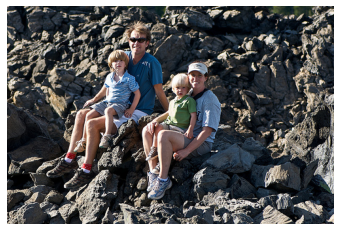

two people sitting on rocks


In [ ]:
random_idx = np.random.randint(0,1000)
imgName = list(test_encode.keys())[random_idx]
pic = test_encode[imgName].reshape((1,2048))
i = plt.imread(images1 + imgName)
plt.imshow(i)
plt.axis("off")
plt.show()
our_caption = predict(pic)
print(our_caption)

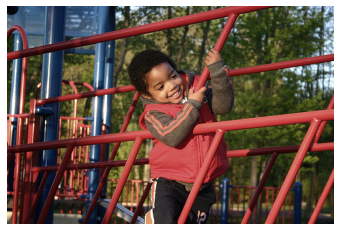

the little girl is playing on the top of wooden fence


In [ ]:
random_idx = np.random.randint(0,1000)
imgName = list(test_encode.keys())[random_idx]
pic = test_encode[imgName].reshape((1,2048))
i = plt.imread(images1 + imgName)
plt.imshow(i)
plt.axis("off")
plt.show()
our_caption = predict(pic)
print(our_caption)

##Summary
Image caption generator is a popular research area. It involves CNN (Convolutional Neural Network) to extract features from the images and LSTM (Long Short Term Memory) used to generate captions for the image.<br>
For this task, we used the flickr8k dataset which consists of 8000 images. For better accuracy, we need to train datasets larger than this.

####References:
* https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/
* https://www.geeksforgeeks.org/image-caption-generator-using-deep-learning-on-flickr8k-dataset/
* https://data-flair.training/blogs/python-based-project-image-caption-generator-cnn/
* https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/